# Case Study: IoT Sensor Failure Detection using GRU
### Overview
Predict imminent machine failure (binary) using last 60 time steps of multivariate sensor data. GRU is chosen as a lightweight alternative to LSTM for real-time systems.


## 1) Why GRU?
GRU has fewer parameters than LSTM and often matches LSTM performance while being faster to train/infer. It's useful in edge or streaming scenarios.

## 2) Synthetic multivariate data generation
We'll create sequences with small anomalies to simulate a sensor drifting into failure.

Shape X: (1500, 60, 6) Shape y: (1500,) Positive rate: 0.362


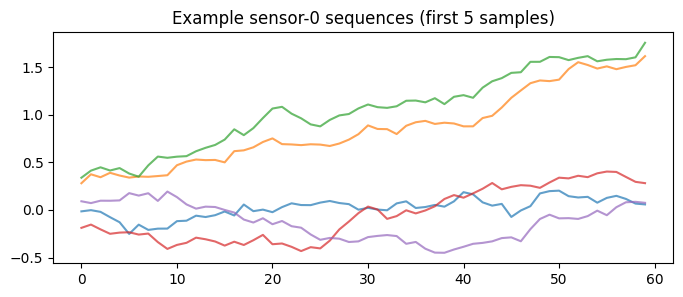

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

np.random.seed(1)
n_series = 1500
timesteps = 60
n_sensors = 6

X = np.zeros((n_series, timesteps, n_sensors), dtype=np.float32)
y = np.zeros((n_series,), dtype=int)

for i in range(n_series):
    base = np.random.normal(0, 0.3, size=(n_sensors,))
    noise = np.random.normal(0, 0.05, size=(timesteps, n_sensors)).cumsum(axis=0)
    # occasionally inject a rising drift in sensor 0 to simulate pre-failure
    if np.random.rand() < 0.25:
        drift = np.linspace(0, np.random.uniform(0.6,1.5), timesteps).reshape(-1,1)
    else:
        drift = np.linspace(0, np.random.uniform(-0.2,0.2), timesteps).reshape(-1,1)
    seq = base + noise + drift
    X[i] = seq
    # label as failure if final sensor0 reading + mean exceeds threshold
    y[i] = 1 if (seq[-1,0] + seq[:,0].mean()) > 0.7 else 0

X, y = shuffle(X, y, random_state=42)
print("Shape X:", X.shape, "Shape y:", y.shape, "Positive rate:", y.mean())

# show a few sequences for sensor 0
plt.figure(figsize=(8,3))
for i in range(5):
    plt.plot(X[i,:,0], alpha=0.7)
plt.title("Example sensor-0 sequences (first 5 samples)")
plt.show()


## 3) Preprocessing and train/test split
We keep data as float arrays — GRU will learn temporal patterns. We'll standardize each sensor channel for stability.

In [2]:
# Standardize per-sensor (fit on train split only for realistic flow)
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [3]:
# reshape to 2D for scaler: (samples*timesteps, sensors)
s = X_train.shape
scaler = StandardScaler()
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_2d)
X_train = scaler.transform(X_train_2d).reshape(s)


In [4]:
# apply to test
X_test_2d = X_test.reshape(-1, X_test.shape[-1])
X_test = scaler.transform(X_test_2d).reshape(X_test.shape)

In [5]:
print("After scaling, sample mean (train):", X_train.mean(), "std (train):", X_train.std())


After scaling, sample mean (train): -2.2605613e-09 std (train): 1.0


## 4) Model architecture & workflow diagram
GRU(64) -> Dense(1, sigmoid). Diagram below.

In [6]:
# Build, train and evaluate GRU model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [7]:
model = Sequential([
    GRU(64, input_shape=(timesteps, n_sensors)),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,889 (54.25 KB)

 Trainable params: 13,889 (54.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
34/34 - 4s - 129ms/step - accuracy: 0.8222 - loss: 0.4497 - val_accuracy: 0.8917 - val_loss: 0.2849
Epoch 2/10
34/34 - 1s - 41ms/step - accuracy: 0.9500 - loss: 0.1504 - val_accuracy: 0.9917 - val_loss: 0.0691
Epoch 3/10
34/34 - 1s - 37ms/step - accuracy: 0.9667 - loss: 0.0805 - val_accuracy: 0.9667 - val_loss: 0.0791
Epoch 4/10
34/34 - 1s - 37ms/step - accuracy: 0.9694 - loss: 0.0786 - val_accuracy: 0.9833 - val_loss: 0.0738
Epoch 5/10
34/34 - 1s - 34ms/step - accuracy: 0.9657 - loss: 0.0792 - val_accuracy: 0.9833 - val_loss: 0.0700
Epoch 6/10
34/34 - 1s - 37ms/step - accuracy: 0.9722 - loss: 0.0689 - val_accuracy: 0.9500 - val_loss: 0.0826
Epoch 7/10
34/34 - 1s - 43ms/step - accuracy: 0.9639 - loss: 0.0690 - val_accuracy: 0.9917 - val_loss: 0.0639
Epoch 8/10
34/34 - 1s - 33ms/step - accuracy: 0.9731 - loss: 0.0643 - val_accuracy: 0.9750 - val_loss: 0.0762
Epoch 9/10
34/34 - 1s - 37ms/step - accuracy: 0.9676 - loss: 0.0663 - val_accuracy: 0.9750 - val_loss: 0.0719
Epoch 10/

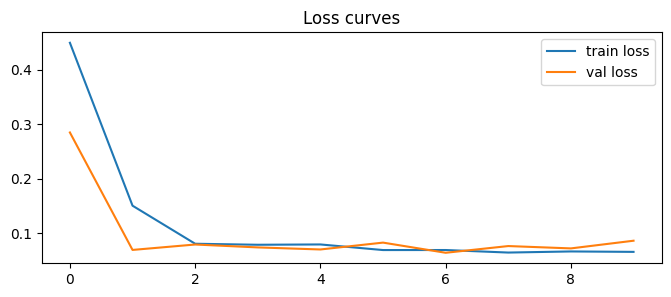

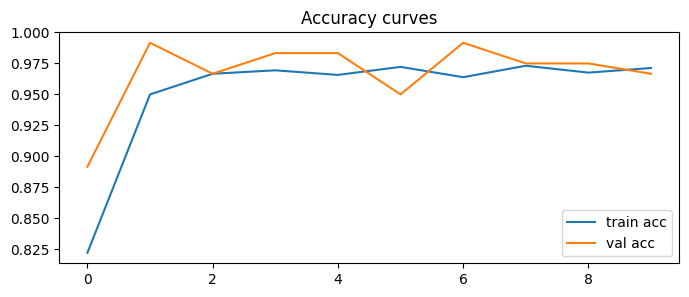

In [10]:
# Plot training curves
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss curves')
plt.legend()
plt.show()

plt.figure(figsize=(8,3))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy curves')
plt.legend()
plt.show()

In [11]:
# Evaluate
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\\n", classification_report(y_test, y_pred))
print("Confusion matrix:\\n", confusion_matrix(y_test, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Accuracy: 0.9733333333333334
Classification report:\n               precision    recall  f1-score   support

           0       1.00      0.96      0.98       191
           1       0.93      1.00      0.96       109

    accuracy                           0.97       300
   macro avg       0.97      0.98      0.97       300
weighted avg       0.98      0.97      0.97       300

Confusion matrix:\n [[183   8]
 [  0 109]]


## 5) Prediction demo and saving model
Run the model on a few test sequences and show probabilities. Save the model for later inference.

In [14]:
# Prediction demo
for i in range(6):
    print(f"True: {int(y_test[i])}, Pred Prob: {float(y_pred_prob[i]):.3f}, Pred: {int(y_pred[i])}")

True: 0, Pred Prob: 0.001, Pred: 0
True: 0, Pred Prob: 0.005, Pred: 0
True: 1, Pred Prob: 0.977, Pred: 1
True: 1, Pred Prob: 0.989, Pred: 1
True: 1, Pred Prob: 0.999, Pred: 1
True: 1, Pred Prob: 1.000, Pred: 1


In [15]:
# Save model
model_path = "gru_iot_model.h5"
model.save(model_path)
print("Saved GRU model to", model_path)

Saved GRU model to gru_iot_model.h5
